<a href="https://colab.research.google.com/github/ibribr/ML/blob/master/EBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Error backpropagation algorithim for Multilayer Perceptron (MLP): one hidden layer - tested with IRIS dataset
# Ibrahim A. Hameed,  09.09.2020  NTNU in Ålesund Norway
import numpy as np
import matplotlib.pyplot as plt
import random 
from keras.utils import to_categorical

In [4]:
class feed_forward(object):
  
  def __init__(self, eta = 0.01, epochs = 100, n_hidden_layer=10, seed=None, shuffle=True, validate=0.2, test=0.2):
    self.eta = eta
    self.epochs = epochs
    self.n_hidden_layer = n_hidden_layer
    self.random = np.random.RandomState(seed)
    self.shuffle = shuffle
    self.validate = validate
    self.test = test
    self.eval_ = {'train_acc': [], 'valid_acc': [], 'test_acc': []}    
  
  def __shuffle(self, x, y):
    indx = self.random.permutation(len(y))
    return x[indx], y[indx]

  def fit(self, x, y):
    # x is n_samples * n_features
    # y is n_samples of n_classes
    
    # shuffle the dataset
    if self.shuffle:
      x, y = self.__shuffle(x,y)
 
    n_samples = x.shape[0]
    n_features = x.shape[1]
    # one-hot encoding of y
    n_classes = np.unique(y).shape[0]
    y = to_categorical(y, num_classes=n_classes)

    # divide data into training and testing sets
    train_index = int((1-self.test)*n_samples)
    xtrain, ytrain, xtest, ytest = x[0:train_index], y[0:train_index], x[train_index:], y[train_index:]
    
    # divide training set into training and validation sets
    train_index = int((1-self.validate)*xtrain.shape[0])
    xtrain, ytrain, xvalid, yvalid = xtrain[0:train_index], ytrain[0:train_index], xtrain[train_index:], ytrain[train_index:]
    
    # weights and bias of hidden layer
    self.wh_ = self.random.normal(loc = 0.0, scale = 1.0, size =(n_features, self.n_hidden_layer))
    self.bh_ = self.random.normal(loc = 0.0, scale = 1.0, size =(self.n_hidden_layer))

    # weights and bias of output layer
    self.wo_ = self.random.normal(loc = 0.0, scale = 1.0, size =(self.n_hidden_layer, n_classes))
    self.bo_ = self.random.normal(loc = 0.0, scale = 1.0, size =(n_classes))

    # SGD
    for i in range(self.epochs):
      for xi, ti in zip(xtrain,ytrain):
        net_h = np.dot(xi, self.wh_)+self.bh_
        output_h = 1./(1.+np.exp(-net_h))
        net_o = np.dot(output_h,self.wo_)+self.bo_
        output = 1./(1.+np.exp(-net_o))

        # update weights of output layer
        delta_o = np.multiply((output - ti), output * (1.-output))
        delta_h = np.dot(self.wo_, delta_o)
        delta_h = np.multiply(delta_h, output_h*(1.-output_h))
        
        self.wh_ += -self.eta * np.dot(xi.reshape(n_features,1), delta_h.reshape(1, self.n_hidden_layer))
        self.bh_ += -self.eta * delta_h  

        self.wo_ += -self.eta * np.dot(output_h.reshape(self.n_hidden_layer,1), delta_o.reshape(1, n_classes))
        self.bo_ += -self.eta * delta_o
      
      #evaluate after each epoch (training, and validation errors)
      ytrain_pred = self.predict(xtrain)
      yvalid_pred = self.predict(xvalid)
      ytest_pred = self.predict(xtest)
      train_acc = np.sum(np.argmax(ytrain, axis=1)==ytrain_pred).astype(np.float)/xtrain.shape[0]
      valid_acc = np.sum(np.argmax(yvalid, axis=1)==yvalid_pred).astype(np.float)/xvalid.shape[0]
      test_acc = np.sum(np.argmax(ytest, axis=1)==ytest_pred).astype(np.float)/xtest.shape[0]
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
      self.eval_['test_acc'].append(test_acc)
      
    return self

  def predict(self, x):
    net_h = np.dot(x, self.wh_) + self.bh_
    output_h = 1/(1+np.exp(-net_h))
    net_o = np.dot(output_h,self.wo_)+self.bo_
    output = 1/(1+np.exp(-net_o))
    #print(output)
    y_pred = np.argmax(output, axis = 1)
    #print(y_pred)
    return(y_pred)




Test Accuracy (%):  90.2666666666667


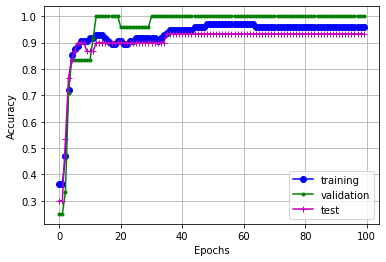

In [27]:
from sklearn.datasets import load_iris

iris = load_iris()
#x = iris.data[0:100,[2,3]]     # petal length and petal width
#x = (x-np.min(x, axis=0))/(np.max(x, axis=0)-np.min(x, axis=0))
#y = iris.target[0:100]

x = iris.data     # petal length and petal width
x = (x-np.min(x, axis=0))/(np.max(x, axis=0)-np.min(x, axis=0))
y = iris.target

model =feed_forward(eta=0.05, epochs=100, shuffle=True, n_hidden_layer=4,validate=0.2, seed=30)
model.fit(x,y)
y_pred = model.predict(x)
accuracy = np.mean(model.eval_['test_acc'])
print('Test Accuracy (%): ', accuracy*100)

plt.figure()
plt.plot(np.arange(model.epochs), model.eval_['train_acc'], linestyle='-', marker='o', color='b',label='training')
plt.plot(np.arange(model.epochs), model.eval_['valid_acc'],linestyle='-', marker='.', color='g',label='validation')
plt.plot(np.arange(model.epochs), model.eval_['test_acc'],linestyle='-', marker='+', color='m',label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()